In [1]:
import os 
import time
import sys 
sys.path.append("../training")
import pickle
import copy
from itertools import combinations, permutations

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import svm, neighbors, cluster, naive_bayes, linear_model

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

# Local imports
from save_data import process_data

np.random.seed(0)

2024-03-25 17:01:01.137556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 17:01:01.251753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-25 17:01:01.251775: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-25 17:01:01.767770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/data/aelabd/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## 1. Data

In [2]:
START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0"

# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

# load data
X_train_val = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y_train_val = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))    
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

In [3]:
# Shuffle train-val
train_val_shuffler = np.random.permutation(range(X_train_val.shape[0]))
X_train_val = X_train_val[train_val_shuffler]
y_train_val = y_train_val[train_val_shuffler]

# Train-validate split
VALIDATION_SPLIT = 0.3
TRAIN_SPLIT = 1 - VALIDATION_SPLIT
N_TRAIN = int(TRAIN_SPLIT*X_train_val.shape[0])

X_train = X_train_val[:N_TRAIN]
y_train = y_train_val[:N_TRAIN]

X_val = X_train_val[N_TRAIN:]
y_val = y_train_val[N_TRAIN:]

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

# One-hot encoded data for neural network
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

y_test_onehot = one_hot_encode(y_test)


X_train.shape: (636300, 1540)
y_train.shape: (636300,)
X_val.shape: (272700, 1540)
y_val.shape: (272700,)
X_test.shape: (101000, 1540)
y_test.shape: (101000,)


In [6]:
y_train_idx0 = np.where(y_train==0)[0]
y_train_idx1 = np.where(y_train==1)[0]

y_val_idx0 = np.where(y_val==0)[0]
y_val_idx1 = np.where(y_val==1)[0]

y_test_idx0 = np.where(y_test==0)[0]
y_test_idx1 = np.where(y_test==1)[0]

## 2. Thresholding, plotting function

In [22]:
# Copied straight from here: https://github.com/openquantumhardware/qick/blob/main/qick_demos/06_qubit_demos.ipynb
# Explanation/in-depth analysis coming soon
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*', alpha=0.1)
        axs[0].scatter(ie, qe, label='e', color='r', marker='*', alpha=0.1)
        axs[0].scatter(xg, yg, color='k', marker='o', alpha=0.1)
        axs[0].scatter(xe, ye, color='k', marker='o', alpha=0.1)
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*', alpha=0.1)
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*', alpha=0.1)
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind] #TODO: Is this the actual formula for quantum state fidelity? Or are they just computing some other metric and calling it 'fidelity'?
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

## 3. Get threshold from training data

In [20]:
def average_and_split(X):
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]

    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    X_I_mean = np.mean(X_I, axis=1)
    X_Q_mean = np.mean(X_Q, axis=1)

    return X_I_mean, X_Q_mean


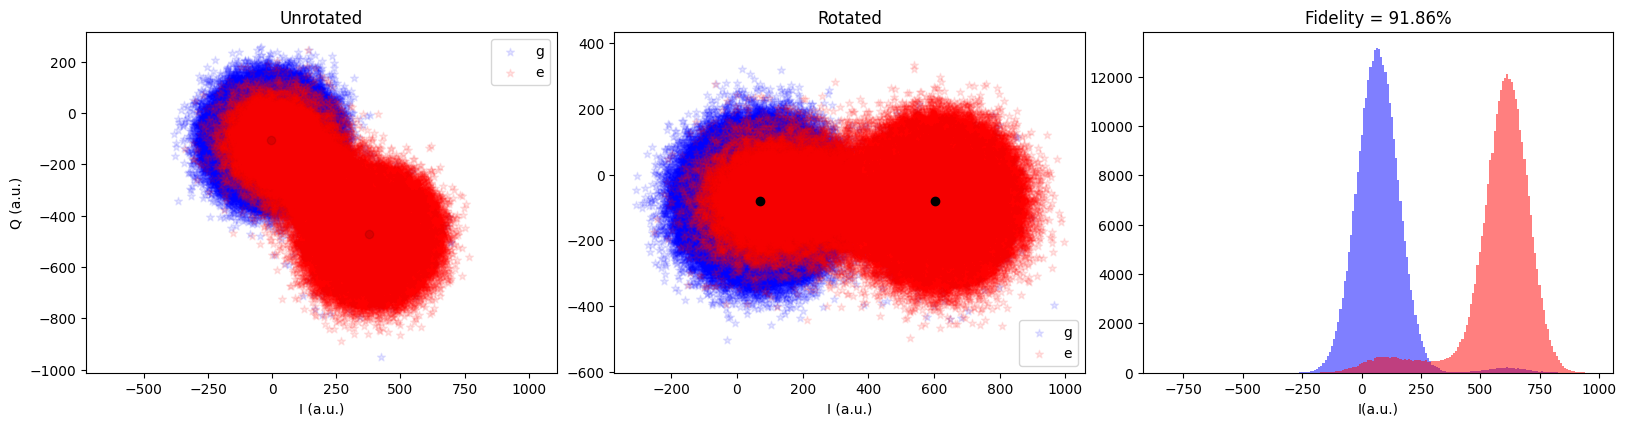

In [49]:
y_train_idx0 = np.where(y_train==0)[0]
X_train_0 = X_train[y_train_idx0, :]
X_train_0_I, X_train_0_Q = average_and_split(X_train_0)

y_train_idx1 = np.where(y_train==1)[0]
X_train_1 = X_train[y_train_idx1, :]
X_train_1_I, X_train_1_Q = average_and_split(X_train_1)

data_train = [X_train_0_I, X_train_0_Q, X_train_1_I, X_train_1_Q]
fid, threshold, theta = hist(data = data_train, plot = True, ran = 900)

## 4. Use training parameters to threshold test data

In [56]:
def threshold_transform(data, theta, threshold):
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    # 1. Rotate data by theta
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)

    # 2. Discriminate based on threshold
    g_labeled_g = np.where(ig_new <= threshold)[0]
    g_labeled_e = np.where(ig_new > threshold)[0]

    e_labeled_g = np.where(ie_new <= threshold)[0]
    e_labeled_e = np.where(ie_new > threshold)[0]

    # 3. Compute accuracy
    true_pos = len(e_labeled_e)
    true_neg = len(g_labeled_g)
    false_pos = len(g_labeled_e)
    false_neg = len(e_labeled_g)
    accuracy = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)

    # 4. Visualize
    ig_labeled_g = ig[g_labeled_g]
    qg_labeled_g = qg[g_labeled_g]

    ig_labeled_e = ig[g_labeled_e]
    qg_labeled_e = qg[g_labeled_e]

    ie_labeled_g = ie[e_labeled_g]
    qe_labeled_g = qe[e_labeled_g]

    ie_labeled_e = ie[e_labeled_e]
    qe_labeled_e = qe[e_labeled_e]

    plt.figure()
    plt.scatter(ig_labeled_g, qg_labeled_g, label = "Ground, labeled ground", alpha = 0.1)
    plt.scatter(ig_labeled_e, qg_labeled_e, label = "Ground, labeled excited", alpha = 0.1)
    plt.scatter(ie_labeled_g, qe_labeled_g, label = "Excited, labeled ground", alpha = 0.1)
    plt.scatter(ie_labeled_e, qe_labeled_e, label = "Excited, labeled excited", alpha = 0.1)

    thresh_x = threshold*np.ones(200)
    thresh_y = np.linspace(-800, 300, 200)
    thresh_x_prime = thresh_x*np.cos(-theta) - thresh_y*np.sin(-theta)
    thresh_y_prime = thresh_x*np.sin(-theta) + thresh_y*np.cos(-theta)
    plt.plot(thresh_x_prime, thresh_y_prime, label = "Discriminating vector")
    
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.title(f"Accuracy: {(100*accuracy):.2f}%")
    plt.legend()
    plt.show()
    

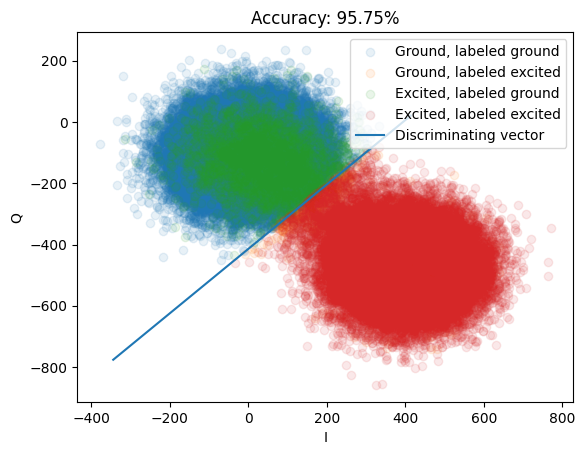

In [57]:
y_test_idx0 = np.where(y_test==0)[0]
X_test_0 = X_test[y_test_idx0, :]
X_test_0_I, X_test_0_Q = average_and_split(X_test_0)

y_test_idx1 = np.where(y_test==1)[0]
X_test_1 = X_test[y_test_idx1, :]
X_test_1_I, X_test_1_Q = average_and_split(X_test_1)

data_test = [X_test_0_I, X_test_0_Q, X_test_1_I, X_test_1_Q]
threshold_transform(data_test, theta, threshold)

Compared to the truth labels

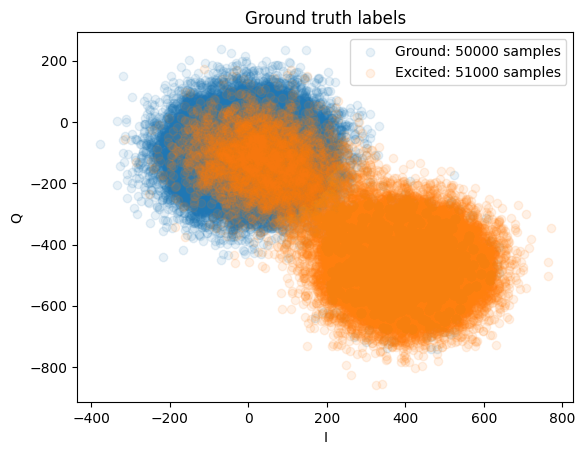

In [48]:
y_truth_idx0 = np.where(y_test==0)[0]
X_truth_0 = X_test[y_truth_idx0, :]
X_truth_0_I, X_truth_0_Q = average_and_split(X_truth_0)

y_truth_idx1 = np.where(y_test==1)[0]
X_truth_1 = X_test[y_truth_idx1, :]
X_truth_1_I, X_truth_1_Q = average_and_split(X_truth_1)

plt.figure()
plt.scatter(X_truth_0_I, X_truth_0_Q, label = f"Ground: {len(y_truth_idx0)} samples", alpha=0.1)
plt.scatter(X_truth_1_I, X_truth_1_Q, label = f"Excited: {len(y_truth_idx1)} samples", alpha=0.1)
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Ground truth labels")
plt.legend()
plt.show()

## TODO: Determine threshold with SVM